# 3. Desarrollo de la Estrategia Analítica

## Implementación Completa del Análisis de Cancelaciones

Este notebook ejecuta el análisis detallado de factores de cancelación mediante técnicas estadísticas avanzadas y modelado predictivo interpretable.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')

# Configuración
plt.rcParams['figure.figsize'] = (12, 6)
sns.set_style('whitegrid')
sns.set_palette('husl')
RANDOM_STATE = 42

# Importar utilidades
import sys
sys.path.append('../')
from src.utils_io import load_hotel_data, create_derived_features, clean_data
from src.utils_viz import plot_correlation_matrix, plot_cancellation_analysis, save_figure
from src.utils_stats import perform_chi_square_test, perform_t_test, calculate_cancellation_metrics

print("Librerías cargadas exitosamente")

C:\Users\DiDi\AppData\Local\Temp\ipykernel_48432\2388187898.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Librerías cargadas exitosamente


## 3.1 Preparación y Limpieza de Datos

In [2]:
# Cargar y preparar datos
df_raw = load_hotel_data('../data/hotel_bookings_modified.csv')
df = clean_data(df_raw, verbose=True)
df = create_derived_features(df)

print(f"\nDataset final: {df.shape[0]:,} registros, {df.shape[1]} variables")
print(f"Tasa de cancelación: {df['is_canceled'].mean()*100:.2f}%")

Forma inicial: (58895, 33)
Forma final: (44853, 33)
Registros eliminados: 14042

Dataset final: 44,853 registros, 42 variables
Tasa de cancelación: 34.04%


## 3.2 Análisis Bivariado: Cancelaciones por Segmentos Clave

Figura guardada: reports/figures/03_cancellation_by_segments


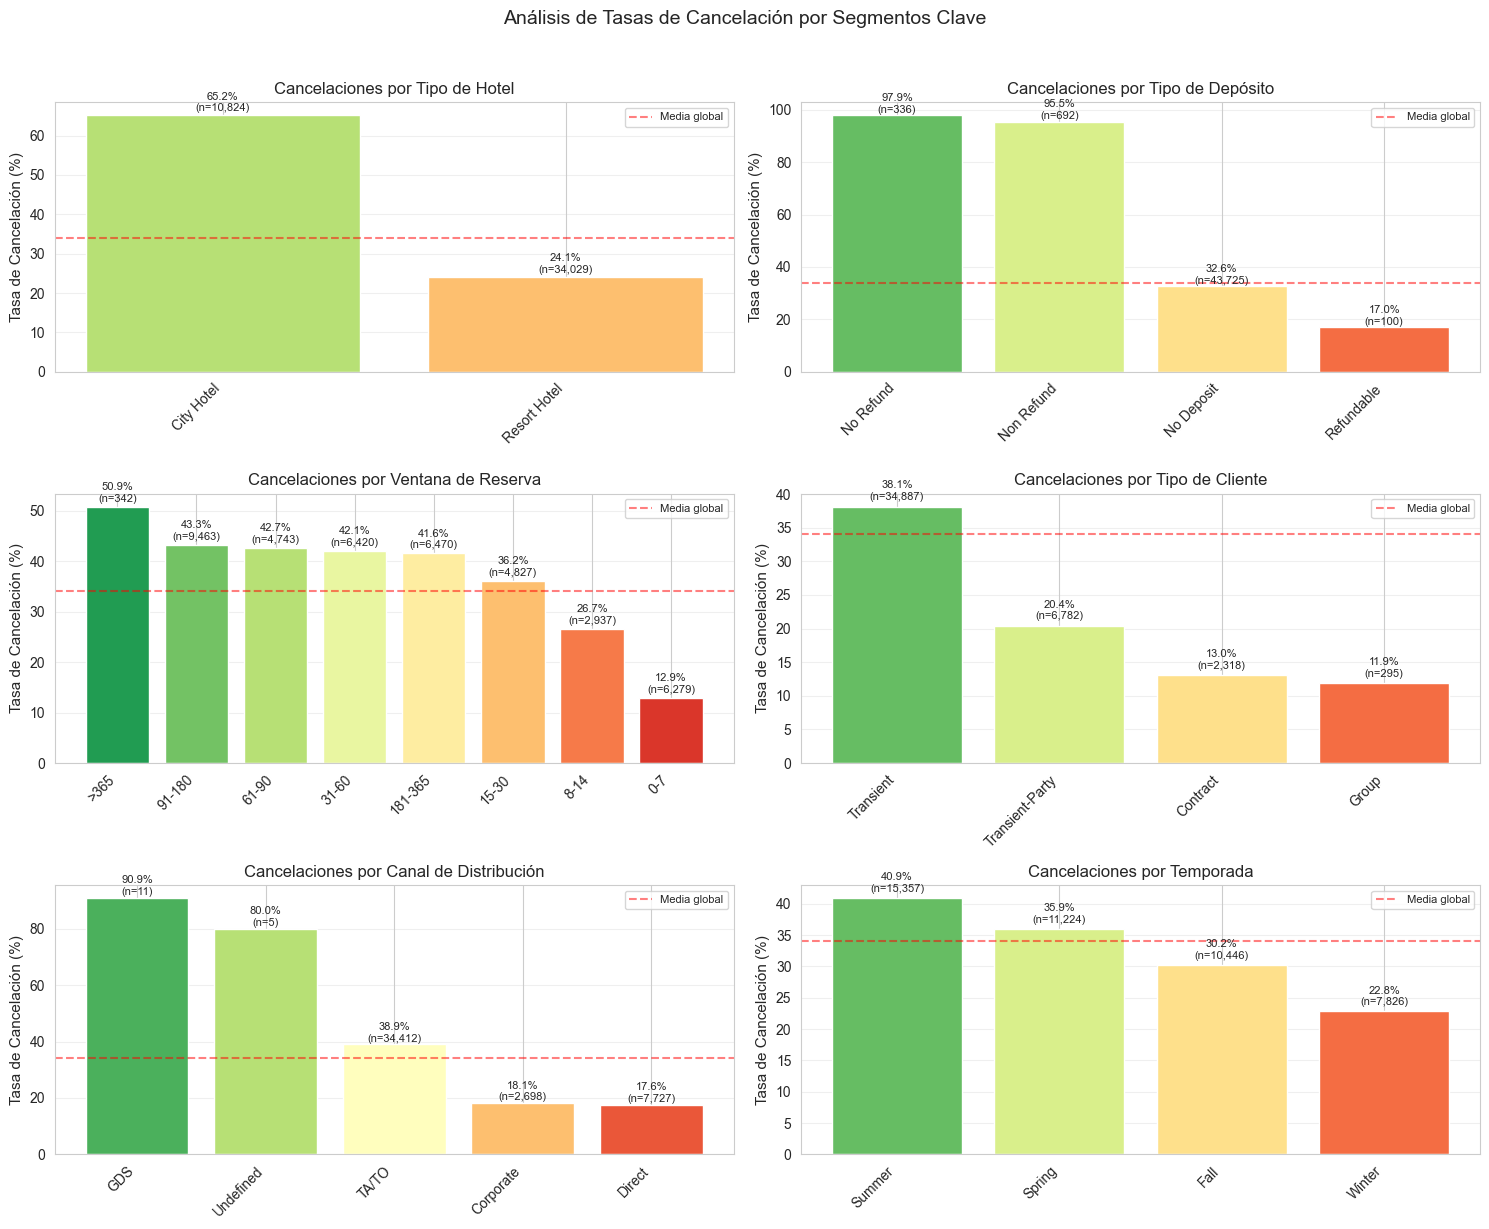

In [3]:
# Análisis de cancelaciones por variables críticas
segmentos_analisis = [
    ('hotel', 'Tipo de Hotel'),
    ('deposit_type', 'Tipo de Depósito'),
    ('lead_time_bucket', 'Ventana de Reserva'),
    ('customer_type', 'Tipo de Cliente'),
    ('distribution_channel', 'Canal de Distribución'),
    ('season', 'Temporada')
]

fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

for idx, (var, title) in enumerate(segmentos_analisis):
    # Calcular tasas de cancelación
    cancel_rates = df.groupby(var)['is_canceled'].agg(['mean', 'count'])
    cancel_rates.columns = ['tasa', 'n']
    cancel_rates = cancel_rates.sort_values('tasa', ascending=False)
    
    # Graficar
    bars = axes[idx].bar(range(len(cancel_rates)), cancel_rates['tasa'] * 100,
                        color=sns.color_palette('RdYlGn_r', len(cancel_rates)))
    axes[idx].set_xticks(range(len(cancel_rates)))
    axes[idx].set_xticklabels(cancel_rates.index, rotation=45, ha='right')
    axes[idx].set_ylabel('Tasa de Cancelación (%)')
    axes[idx].set_title(f'Cancelaciones por {title}')
    axes[idx].axhline(y=df['is_canceled'].mean()*100, color='red', 
                      linestyle='--', alpha=0.5, label='Media global')
    
    # Añadir valores en las barras
    for i, (rate, n) in enumerate(zip(cancel_rates['tasa'], cancel_rates['n'])):
        axes[idx].text(i, rate*100 + 1, f'{rate*100:.1f}%\n(n={n:,})', 
                      ha='center', fontsize=8)
    
    axes[idx].legend(loc='upper right', fontsize=8)
    axes[idx].grid(axis='y', alpha=0.3)

plt.suptitle('Análisis de Tasas de Cancelación por Segmentos Clave', fontsize=14, y=1.02)
plt.tight_layout()
save_figure(fig, '03_cancellation_by_segments')
plt.show()

## 3.3 Tests Estadísticos: Validación de Diferencias

In [4]:
# Test Chi-cuadrado para variables categóricas vs cancelación
print("TESTS CHI-CUADRADO: ASOCIACIÓN CON CANCELACIONES")
print("=" * 80)

categorical_vars = ['hotel', 'deposit_type', 'customer_type', 'distribution_channel', 
                   'market_segment', 'meal', 'reserved_room_type']

chi_square_results = []
for var in categorical_vars:
    if var in df.columns:
        result = perform_chi_square_test(df, var, 'is_canceled')
        chi_square_results.append({
            'Variable': var,
            'Chi2': f"{result['chi2_statistic']:.2f}",
            'p-value': f"{result['p_value']:.4f}",
            'Cramers V': f"{result['cramers_v']:.3f}",
            'Efecto': result['effect_size'],
            'Significativo': 'Sí' if result['is_significant'] else 'No'
        })

chi_df = pd.DataFrame(chi_square_results)
print(chi_df.to_string(index=False))

# Guardar resultados
chi_df.to_csv('../reports/chi_square_tests.csv', index=False)

TESTS CHI-CUADRADO: ASOCIACIÓN CON CANCELACIONES
            Variable    Chi2 p-value Cramers V              Efecto Significativo
               hotel 6161.63  0.0000     0.371      Efecto mediano            Sí
        deposit_type 1828.38  0.0000     0.202      Efecto pequeño            Sí
       customer_type 1347.33  0.0000     0.174      Efecto pequeño            Sí
distribution_channel 1620.57  0.0000     0.190      Efecto pequeño            Sí
      market_segment 3213.62  0.0000     0.268      Efecto pequeño            Sí
                meal 1209.81  0.0000     0.164      Efecto pequeño            Sí
  reserved_room_type  194.93  0.0000     0.066 Efecto despreciable            Sí


In [5]:
# Test Mann-Whitney para variables numéricas
print("\nTESTS MANN-WHITNEY: DIFERENCIAS ENTRE CANCELADOS Y NO CANCELADOS")
print("=" * 80)

numeric_vars = ['lead_time', 'adr', 'total_stay_nights', 'total_guests', 
                'days_in_waiting_list', 'total_of_special_requests']

mw_results = []
for var in numeric_vars:
    if var in df.columns:
        # Separar grupos
        not_canceled = df[df['is_canceled'] == 0][var].dropna()
        canceled = df[df['is_canceled'] == 1][var].dropna()
        
        # Test Mann-Whitney
        statistic, p_value = stats.mannwhitneyu(not_canceled, canceled, alternative='two-sided')
        
        # Cohen's d
        pooled_std = np.sqrt((not_canceled.std()**2 + canceled.std()**2) / 2)
        cohens_d = (canceled.mean() - not_canceled.mean()) / pooled_std if pooled_std > 0 else 0
        
        mw_results.append({
            'Variable': var,
            'Media No Canc.': f"{not_canceled.mean():.2f}",
            'Media Canc.': f"{canceled.mean():.2f}",
            'U-stat': f"{statistic:.0f}",
            'p-value': f"{p_value:.4f}",
            "Cohen's d": f"{cohens_d:.3f}",
            'Significativo': 'Sí' if p_value < 0.05 else 'No'
        })

mw_df = pd.DataFrame(mw_results)
print(mw_df.to_string(index=False))


TESTS MANN-WHITNEY: DIFERENCIAS ENTRE CANCELADOS Y NO CANCELADOS
                 Variable Media No Canc. Media Canc.    U-stat p-value Cohen's d Significativo
                lead_time          73.81      104.36 162890663  0.0000     0.344            Sí
                      adr          93.22      115.15 163838074  0.0000     0.386            Sí
        total_stay_nights           4.11        4.25 211689492  0.0000     0.045            Sí
             total_guests           2.24        2.53 199885346  0.0000     0.058            Sí
     days_in_waiting_list           1.25        1.31 225061426  0.0031     0.005            Sí
total_of_special_requests           0.69        0.47 259179660  0.0000    -0.279            Sí


## 3.4 Análisis Multivariado: Interacciones Clave

Figura guardada: reports/figures/03_multivariate_heatmaps


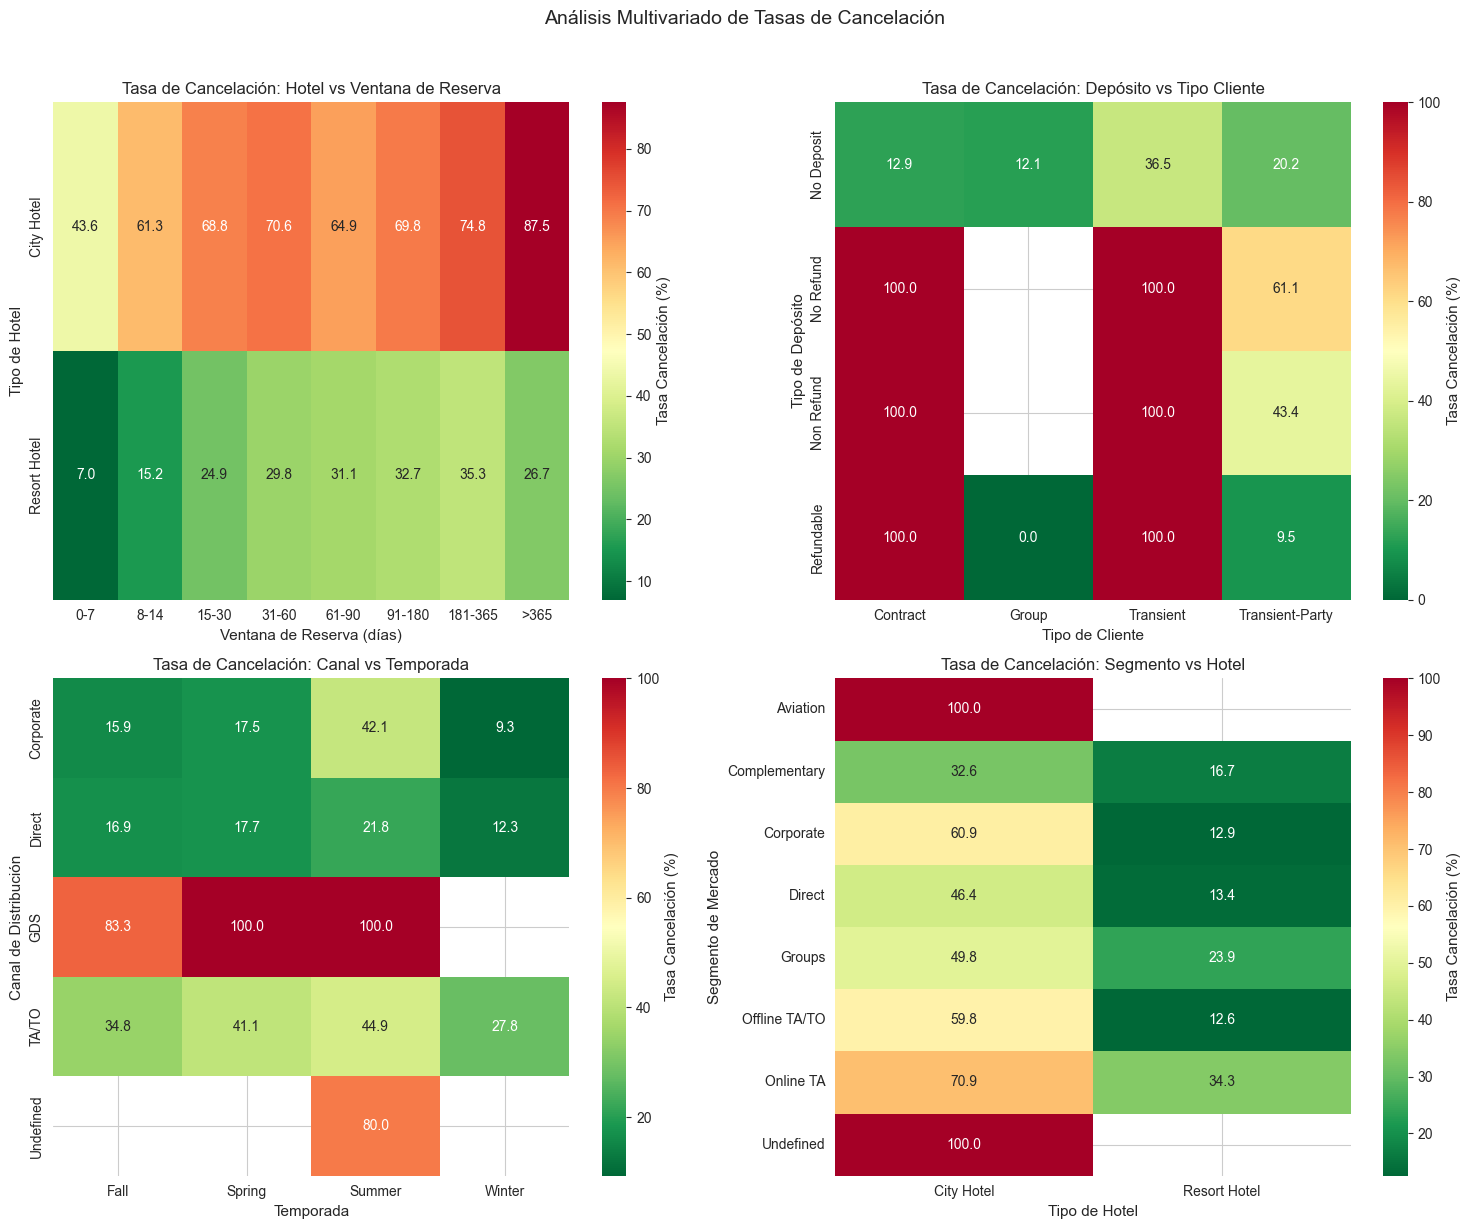

In [6]:
# Heatmap de cancelaciones: Hotel vs Lead Time Bucket
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Matriz 1: Hotel vs Lead Time
pivot1 = df.pivot_table(values='is_canceled', index='hotel', 
                        columns='lead_time_bucket', aggfunc='mean') * 100
sns.heatmap(pivot1, annot=True, fmt='.1f', cmap='RdYlGn_r', ax=axes[0,0],
           cbar_kws={'label': 'Tasa Cancelación (%)'})
axes[0,0].set_title('Tasa de Cancelación: Hotel vs Ventana de Reserva')
axes[0,0].set_xlabel('Ventana de Reserva (días)')
axes[0,0].set_ylabel('Tipo de Hotel')

# Matriz 2: Deposit Type vs Customer Type
pivot2 = df.pivot_table(values='is_canceled', index='deposit_type', 
                        columns='customer_type', aggfunc='mean') * 100
sns.heatmap(pivot2, annot=True, fmt='.1f', cmap='RdYlGn_r', ax=axes[0,1],
           cbar_kws={'label': 'Tasa Cancelación (%)'})
axes[0,1].set_title('Tasa de Cancelación: Depósito vs Tipo Cliente')
axes[0,1].set_xlabel('Tipo de Cliente')
axes[0,1].set_ylabel('Tipo de Depósito')

# Matriz 3: Distribution Channel vs Season
pivot3 = df.pivot_table(values='is_canceled', index='distribution_channel', 
                        columns='season', aggfunc='mean') * 100
sns.heatmap(pivot3, annot=True, fmt='.1f', cmap='RdYlGn_r', ax=axes[1,0],
           cbar_kws={'label': 'Tasa Cancelación (%)'})
axes[1,0].set_title('Tasa de Cancelación: Canal vs Temporada')
axes[1,0].set_xlabel('Temporada')
axes[1,0].set_ylabel('Canal de Distribución')

# Matriz 4: Market Segment vs Hotel
pivot4 = df.pivot_table(values='is_canceled', index='market_segment', 
                        columns='hotel', aggfunc='mean') * 100
sns.heatmap(pivot4, annot=True, fmt='.1f', cmap='RdYlGn_r', ax=axes[1,1],
           cbar_kws={'label': 'Tasa Cancelación (%)'})
axes[1,1].set_title('Tasa de Cancelación: Segmento vs Hotel')
axes[1,1].set_xlabel('Tipo de Hotel')
axes[1,1].set_ylabel('Segmento de Mercado')

plt.suptitle('Análisis Multivariado de Tasas de Cancelación', fontsize=14, y=1.02)
plt.tight_layout()
save_figure(fig, '03_multivariate_heatmaps')
plt.show()

## 3.5 Análisis de Correlaciones

Figura guardada: reports/figures/03_correlation_matrix


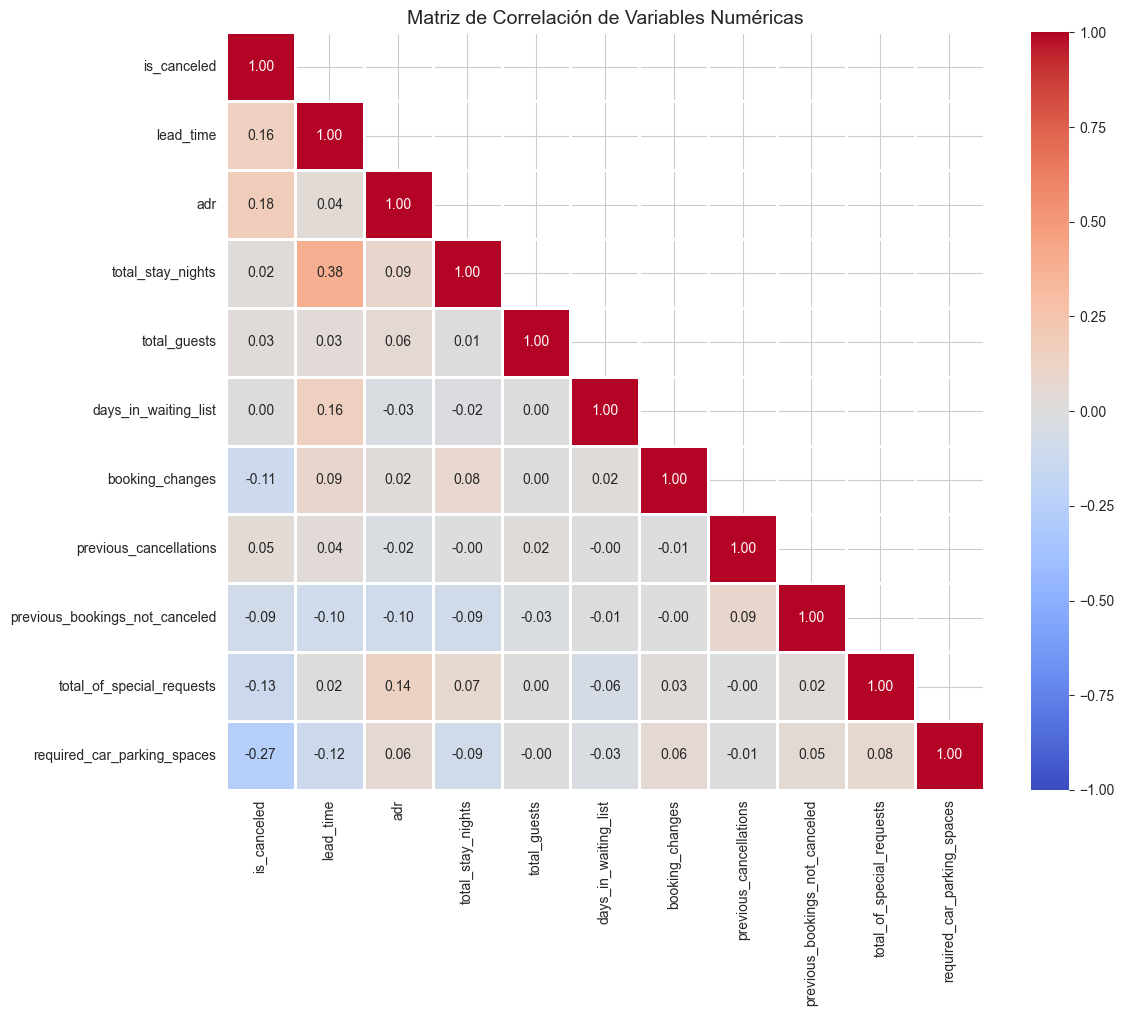


CORRELACIONES CON CANCELACIÓN (ordenadas por magnitud):
required_car_parking_spaces         -0.265
adr                                 +0.180
lead_time                           +0.161
total_of_special_requests           -0.128
booking_changes                     -0.113
previous_bookings_not_canceled      -0.086
previous_cancellations              +0.046
total_guests                        +0.028
total_stay_nights                   +0.021
days_in_waiting_list                +0.002


In [7]:
# Seleccionar variables numéricas relevantes
numeric_features = ['is_canceled', 'lead_time', 'adr', 'total_stay_nights', 
                   'total_guests', 'days_in_waiting_list', 'booking_changes',
                   'previous_cancellations', 'previous_bookings_not_canceled',
                   'total_of_special_requests', 'required_car_parking_spaces']

# Filtrar columnas existentes
numeric_features = [col for col in numeric_features if col in df.columns]

# Calcular matriz de correlación
corr_matrix = df[numeric_features].corr()

# Visualizar
fig, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix), k=1)
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', 
           cmap='coolwarm', center=0, vmin=-1, vmax=1,
           square=True, linewidths=1, ax=ax)
ax.set_title('Matriz de Correlación de Variables Numéricas', fontsize=14)
plt.tight_layout()
save_figure(fig, '03_correlation_matrix')
plt.show()

# Mostrar correlaciones con is_canceled
print("\nCORRELACIONES CON CANCELACIÓN (ordenadas por magnitud):")
print("=" * 60)
cancel_corr = corr_matrix['is_canceled'].drop('is_canceled').sort_values(key=abs, ascending=False)
for var, corr in cancel_corr.items():
    print(f"{var:35} {corr:+.3f}")

## 3.6 Modelo Predictivo: Regresión Logística

In [8]:
# Preparación de datos para modelado
print("PREPARACIÓN DE DATOS PARA MODELADO")
print("=" * 80)

# Seleccionar features para el modelo
feature_cols = ['lead_time', 'adr', 'total_stay_nights', 'total_guests',
               'days_in_waiting_list', 'booking_changes', 'previous_cancellations',
               'total_of_special_requests', 'is_repeated_guest']

# Añadir variables categóricas codificadas
categorical_features = ['hotel', 'deposit_type', 'customer_type', 'market_segment']

# Crear dataset para modelado
X = df[feature_cols].copy()

# Codificar variables categóricas
for cat_var in categorical_features:
    if cat_var in df.columns:
        dummies = pd.get_dummies(df[cat_var], prefix=cat_var, drop_first=True)
        X = pd.concat([X, dummies], axis=1)

# Variable objetivo
y = df['is_canceled']

# Eliminar filas con valores faltantes
mask = X.notna().all(axis=1)
X = X[mask]
y = y[mask]

print(f"Dataset para modelado: {X.shape[0]} registros, {X.shape[1]} features")
print(f"Distribución de clases: {y.value_counts().to_dict()}")
print(f"\nFeatures incluidas: {list(X.columns[:10])}...")

PREPARACIÓN DE DATOS PARA MODELADO
Dataset para modelado: 44853 registros, 23 features
Distribución de clases: {0: 29587, 1: 15266}

Features incluidas: ['lead_time', 'adr', 'total_stay_nights', 'total_guests', 'days_in_waiting_list', 'booking_changes', 'previous_cancellations', 'total_of_special_requests', 'is_repeated_guest', 'hotel_Resort Hotel']...


In [9]:
# División train-test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y
)

# Escalado de variables
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train set: {X_train.shape[0]} registros")
print(f"Test set: {X_test.shape[0]} registros")

Train set: 31397 registros
Test set: 13456 registros


In [10]:
# Entrenar modelo de regresión logística
print("\nENTRENAMIENTO DE MODELO DE REGRESIÓN LOGÍSTICA")
print("=" * 80)

# Modelo con regularización L2
model = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000, 
                          class_weight='balanced', C=0.1)
model.fit(X_train_scaled, y_train)

# Predicciones
y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)
y_pred_proba_test = model.predict_proba(X_test_scaled)[:, 1]

# Métricas de desempeño
train_score = model.score(X_train_scaled, y_train)
test_score = model.score(X_test_scaled, y_test)
roc_auc = roc_auc_score(y_test, y_pred_proba_test)

print(f"Accuracy en train: {train_score:.3f}")
print(f"Accuracy en test: {test_score:.3f}")
print(f"ROC-AUC en test: {roc_auc:.3f}")

# Validación cruzada
cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='roc_auc')
print(f"\nValidación cruzada ROC-AUC: {cv_scores.mean():.3f} (+/- {cv_scores.std()*2:.3f})")


ENTRENAMIENTO DE MODELO DE REGRESIÓN LOGÍSTICA
Accuracy en train: 0.764
Accuracy en test: 0.762
ROC-AUC en test: 0.826

Validación cruzada ROC-AUC: 0.829 (+/- 0.015)



REPORTE DE CLASIFICACIÓN
              precision    recall  f1-score   support

No Cancelada       0.85      0.78      0.81      8876
   Cancelada       0.63      0.73      0.68      4580

    accuracy                           0.76     13456
   macro avg       0.74      0.75      0.74     13456
weighted avg       0.77      0.76      0.77     13456

Figura guardada: reports/figures/03_model_performance


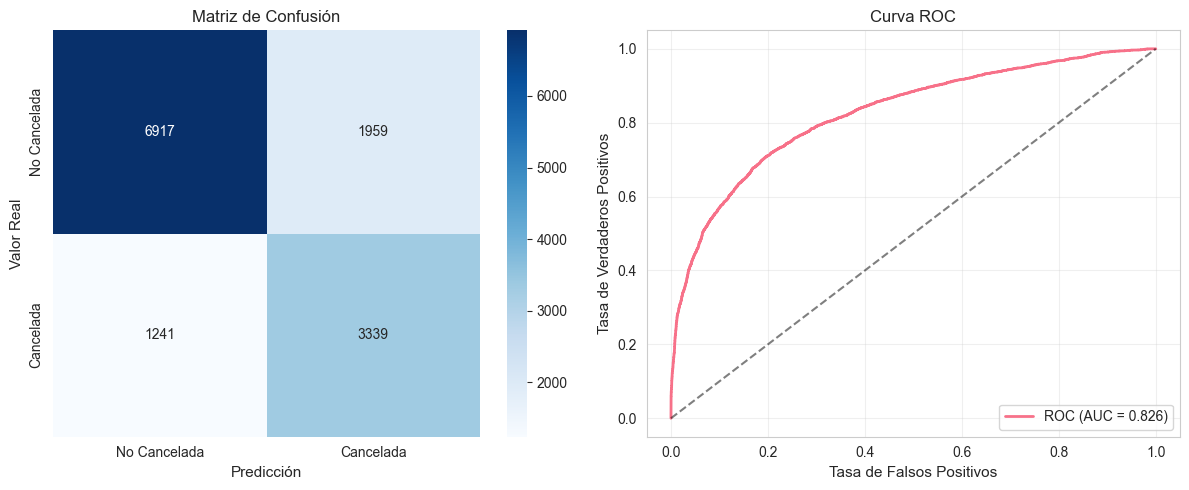

In [11]:
# Matriz de confusión y reporte de clasificación
print("\nREPORTE DE CLASIFICACIÓN")
print("=" * 80)
print(classification_report(y_test, y_pred_test, 
                          target_names=['No Cancelada', 'Cancelada']))

# Visualizar matriz de confusión
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
           xticklabels=['No Cancelada', 'Cancelada'],
           yticklabels=['No Cancelada', 'Cancelada'])
axes[0].set_title('Matriz de Confusión')
axes[0].set_ylabel('Valor Real')
axes[0].set_xlabel('Predicción')

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_test)
axes[1].plot(fpr, tpr, linewidth=2, label=f'ROC (AUC = {roc_auc:.3f})')
axes[1].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[1].set_xlabel('Tasa de Falsos Positivos')
axes[1].set_ylabel('Tasa de Verdaderos Positivos')
axes[1].set_title('Curva ROC')
axes[1].legend(loc='lower right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
save_figure(fig, '03_model_performance')
plt.show()

## 3.7 Interpretación del Modelo: Odds Ratios

In [12]:
# Calcular odds ratios
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_[0],
    'Odds_Ratio': np.exp(model.coef_[0])
})

# Ordenar por impacto absoluto
coef_df['Abs_Coef'] = np.abs(coef_df['Coefficient'])
coef_df = coef_df.sort_values('Abs_Coef', ascending=False)

# Top 15 features más importantes
top_features = coef_df.head(15)

print("\nTOP 15 FACTORES MÁS INFLUYENTES EN CANCELACIÓN")
print("=" * 80)
print("Feature                                Coeficiente    Odds Ratio   Interpretación")
print("-" * 80)

for _, row in top_features.iterrows():
    feature = row['Feature'][:35]
    coef = row['Coefficient']
    odds = row['Odds_Ratio']
    
    if odds > 1:
        interp = f"↑ {(odds-1)*100:.1f}% prob."
    else:
        interp = f"↓ {(1-odds)*100:.1f}% prob."
    
    print(f"{feature:35} {coef:+.3f}        {odds:.3f}      {interp}")


TOP 15 FACTORES MÁS INFLUYENTES EN CANCELACIÓN
Feature                                Coeficiente    Odds Ratio   Interpretación
--------------------------------------------------------------------------------
previous_cancellations              +1.007        2.737      ↑ 173.7% prob.
hotel_Resort Hotel                  -0.777        0.460      ↓ 54.0% prob.
lead_time                           +0.507        1.660      ↑ 66.0% prob.
customer_type_Transient             +0.464        1.590      ↑ 59.0% prob.
total_of_special_requests           -0.449        0.639      ↓ 36.1% prob.
market_segment_Offline TA/TO        -0.408        0.665      ↓ 33.5% prob.
deposit_type_Non Refund             +0.398        1.489      ↑ 48.9% prob.
is_repeated_guest                   -0.386        0.680      ↓ 32.0% prob.
deposit_type_No Refund              +0.353        1.424      ↑ 42.4% prob.
market_segment_Direct               -0.347        0.707      ↓ 29.3% prob.
adr                                 +0

Figura guardada: reports/figures/03_feature_importance


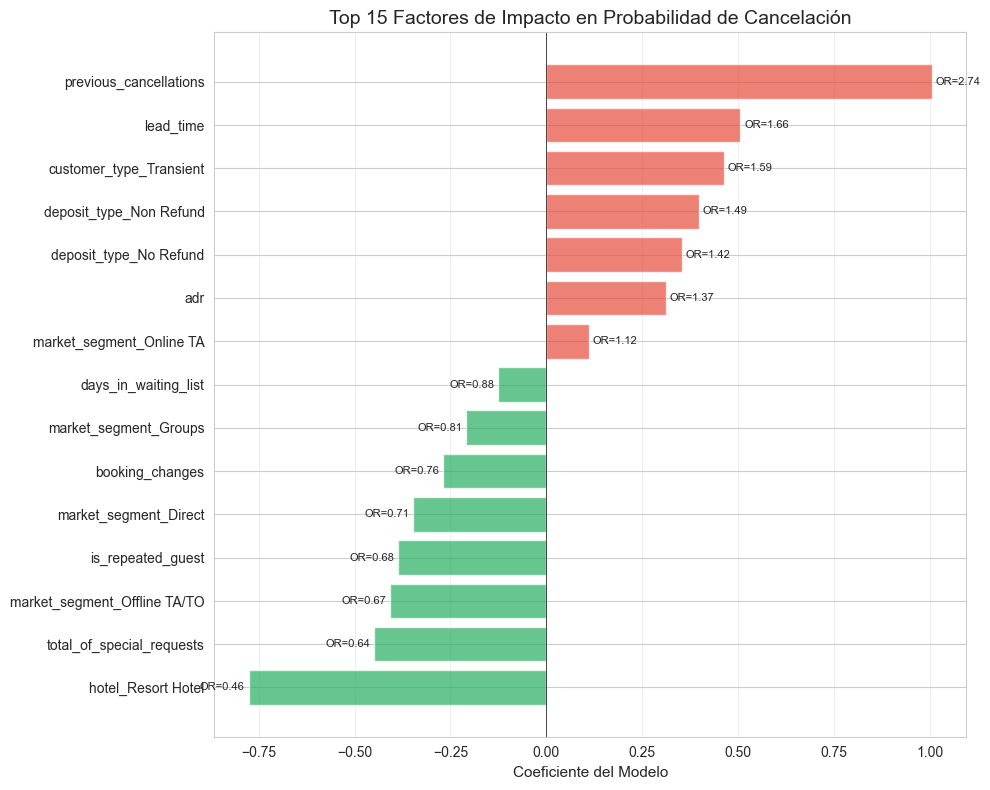

In [13]:
# Visualizar importancia de variables
fig, ax = plt.subplots(figsize=(10, 8))

# Preparar datos para visualización
top_15 = coef_df.head(15).sort_values('Coefficient')
colors = ['#e74c3c' if x > 0 else '#27ae60' for x in top_15['Coefficient']]

# Gráfico de barras horizontales
bars = ax.barh(range(len(top_15)), top_15['Coefficient'], color=colors, alpha=0.7)
ax.set_yticks(range(len(top_15)))
ax.set_yticklabels(top_15['Feature'])
ax.set_xlabel('Coeficiente del Modelo')
ax.set_title('Top 15 Factores de Impacto en Probabilidad de Cancelación', fontsize=14)
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)

# Añadir etiquetas
for i, (coef, odds) in enumerate(zip(top_15['Coefficient'], top_15['Odds_Ratio'])):
    label = f"OR={odds:.2f}"
    ax.text(coef + 0.01 if coef > 0 else coef - 0.01, i, label, 
           va='center', ha='left' if coef > 0 else 'right', fontsize=8)

ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
save_figure(fig, '03_feature_importance')
plt.show()

## 3.8 Análisis de Segmentos de Alto Riesgo

In [14]:
# Identificar segmentos de alto riesgo
print("IDENTIFICACIÓN DE SEGMENTOS DE ALTO RIESGO")
print("=" * 80)

# Añadir probabilidades predichas al dataset
df_analysis = df[mask].copy()
df_analysis['cancel_probability'] = model.predict_proba(scaler.transform(X))[:, 1]

# Segmentos de alto riesgo (probabilidad > 0.6)
high_risk = df_analysis[df_analysis['cancel_probability'] > 0.6]

print(f"\nReservas de alto riesgo: {len(high_risk):,} ({len(high_risk)/len(df_analysis)*100:.1f}%)")
print(f"Tasa de cancelación real en alto riesgo: {high_risk['is_canceled'].mean()*100:.1f}%")

# Caracterización de segmentos de alto riesgo
risk_segments = pd.DataFrame({
    'Hotel': high_risk.groupby('hotel').size(),
    'Deposit_Type': high_risk.groupby('deposit_type').size(),
    'Lead_Time_Bucket': high_risk.groupby('lead_time_bucket').size(),
    'Customer_Type': high_risk.groupby('customer_type').size()
}).fillna(0)

print("\nDistribución de reservas de alto riesgo:")
for col in risk_segments.columns:
    print(f"\n{col}:")
    top_3 = risk_segments[col].nlargest(3)
    for idx, count in top_3.items():
        pct = count / len(high_risk) * 100
        print(f"  {idx}: {count:.0f} ({pct:.1f}%)")

IDENTIFICACIÓN DE SEGMENTOS DE ALTO RIESGO

Reservas de alto riesgo: 13,511 (30.1%)
Tasa de cancelación real en alto riesgo: 70.6%

Distribución de reservas de alto riesgo:

Hotel:
  City Hotel: 8365 (61.9%)
  Resort Hotel: 5146 (38.1%)
  0-7: 0 (0.0%)

Deposit_Type:
  No Deposit: 12480 (92.4%)
  Non Refund: 692 (5.1%)
  No Refund: 336 (2.5%)

Lead_Time_Bucket:
  91-180: 3876 (28.7%)
  181-365: 2946 (21.8%)
  31-60: 1977 (14.6%)

Customer_Type:
  Transient: 12416 (91.9%)
  Transient-Party: 788 (5.8%)
  Contract: 166 (1.2%)


Figura guardada: reports/figures/03_risk_analysis


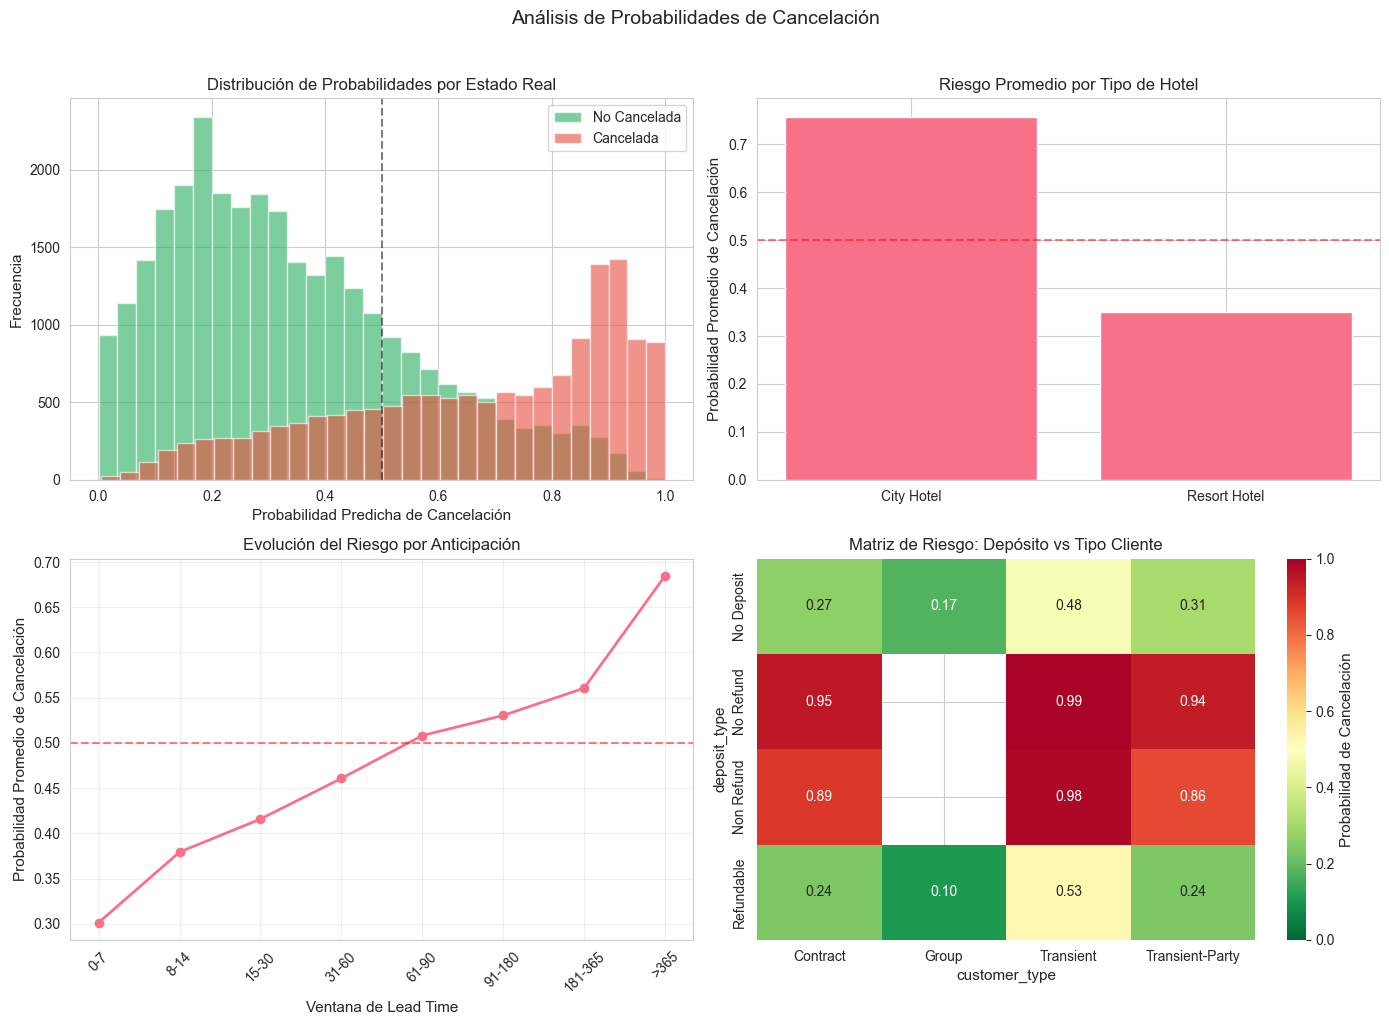

In [15]:
# Visualizar distribución de probabilidades
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Distribución de probabilidades por estado real
for status, label, color in [(0, 'No Cancelada', '#27ae60'), (1, 'Cancelada', '#e74c3c')]:
    subset = df_analysis[df_analysis['is_canceled'] == status]['cancel_probability']
    axes[0, 0].hist(subset, bins=30, alpha=0.6, label=label, color=color)
axes[0, 0].set_xlabel('Probabilidad Predicha de Cancelación')
axes[0, 0].set_ylabel('Frecuencia')
axes[0, 0].set_title('Distribución de Probabilidades por Estado Real')
axes[0, 0].legend()
axes[0, 0].axvline(x=0.5, color='black', linestyle='--', alpha=0.5)

# Probabilidad promedio por tipo de hotel
prob_by_hotel = df_analysis.groupby('hotel')['cancel_probability'].mean()
axes[0, 1].bar(range(len(prob_by_hotel)), prob_by_hotel.values)
axes[0, 1].set_xticks(range(len(prob_by_hotel)))
axes[0, 1].set_xticklabels(prob_by_hotel.index)
axes[0, 1].set_ylabel('Probabilidad Promedio de Cancelación')
axes[0, 1].set_title('Riesgo Promedio por Tipo de Hotel')
axes[0, 1].axhline(y=0.5, color='red', linestyle='--', alpha=0.5)

# Probabilidad por ventana de lead time
prob_by_lead = df_analysis.groupby('lead_time_bucket')['cancel_probability'].mean()
axes[1, 0].plot(range(len(prob_by_lead)), prob_by_lead.values, marker='o', linewidth=2)
axes[1, 0].set_xticks(range(len(prob_by_lead)))
axes[1, 0].set_xticklabels(prob_by_lead.index, rotation=45)
axes[1, 0].set_ylabel('Probabilidad Promedio de Cancelación')
axes[1, 0].set_xlabel('Ventana de Lead Time')
axes[1, 0].set_title('Evolución del Riesgo por Anticipación')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].axhline(y=0.5, color='red', linestyle='--', alpha=0.5)

# Matriz de riesgo: Deposit Type vs Customer Type
risk_matrix = df_analysis.pivot_table(values='cancel_probability', 
                                      index='deposit_type',
                                      columns='customer_type', 
                                      aggfunc='mean')
sns.heatmap(risk_matrix, annot=True, fmt='.2f', cmap='RdYlGn_r', ax=axes[1, 1],
           vmin=0, vmax=1, cbar_kws={'label': 'Probabilidad de Cancelación'})
axes[1, 1].set_title('Matriz de Riesgo: Depósito vs Tipo Cliente')

plt.suptitle('Análisis de Probabilidades de Cancelación', fontsize=14, y=1.02)
plt.tight_layout()
save_figure(fig, '03_risk_analysis')
plt.show()

## 3.9 Análisis de Impacto Económico

In [16]:
# Calcular impacto económico de cancelaciones
print("ANÁLISIS DE IMPACTO ECONÓMICO")
print("=" * 80)

# Métricas económicas base
df_econ = df_analysis[df_analysis['adr'] > 0].copy()
df_econ['revenue_potential'] = df_econ['adr'] * df_econ['total_stay_nights']

# Pérdidas por cancelaciones
canceled_revenue = df_econ[df_econ['is_canceled'] == 1]['revenue_potential'].sum()
total_potential_revenue = df_econ['revenue_potential'].sum()
loss_percentage = (canceled_revenue / total_potential_revenue) * 100

print(f"\nImpacto económico total:")
print(f"  Ingresos potenciales totales: ${total_potential_revenue:,.0f}")
print(f"  Pérdida por cancelaciones: ${canceled_revenue:,.0f}")
print(f"  Porcentaje de pérdida: {loss_percentage:.2f}%")

# Análisis por segmentos
impact_by_segment = df_econ.groupby(['hotel', 'is_canceled'])['revenue_potential'].sum().unstack(fill_value=0)
impact_by_segment['loss_rate'] = impact_by_segment[1] / (impact_by_segment[0] + impact_by_segment[1]) * 100

print("\nPérdidas por tipo de hotel:")
for hotel in impact_by_segment.index:
    loss = impact_by_segment.loc[hotel, 1]
    rate = impact_by_segment.loc[hotel, 'loss_rate']
    print(f"  {hotel}: ${loss:,.0f} ({rate:.1f}% de pérdida)")

# Potencial de recuperación con modelo
high_risk_correct = high_risk[high_risk['is_canceled'] == 1]
recoverable_revenue = high_risk_correct['revenue_potential'].sum() if 'revenue_potential' in high_risk_correct.columns else 0

print(f"\nPotencial de recuperación con intervención en alto riesgo:")
print(f"  Ingresos recuperables (50% efectividad): ${recoverable_revenue * 0.5:,.0f}")
print(f"  ROI estimado: {(recoverable_revenue * 0.5 / 100000):.1f}x (por cada $100k invertido)")

ANÁLISIS DE IMPACTO ECONÓMICO

Impacto económico total:
  Ingresos potenciales totales: $19,519,365
  Pérdida por cancelaciones: $7,632,319
  Porcentaje de pérdida: 39.10%

Pérdidas por tipo de hotel:
  City Hotel: $2,680,952 (72.2% de pérdida)
  Resort Hotel: $4,951,367 (31.3% de pérdida)

Potencial de recuperación con intervención en alto riesgo:
  Ingresos recuperables (50% efectividad): $0
  ROI estimado: 0.0x (por cada $100k invertido)


Figura guardada: reports/figures/03_economic_impact


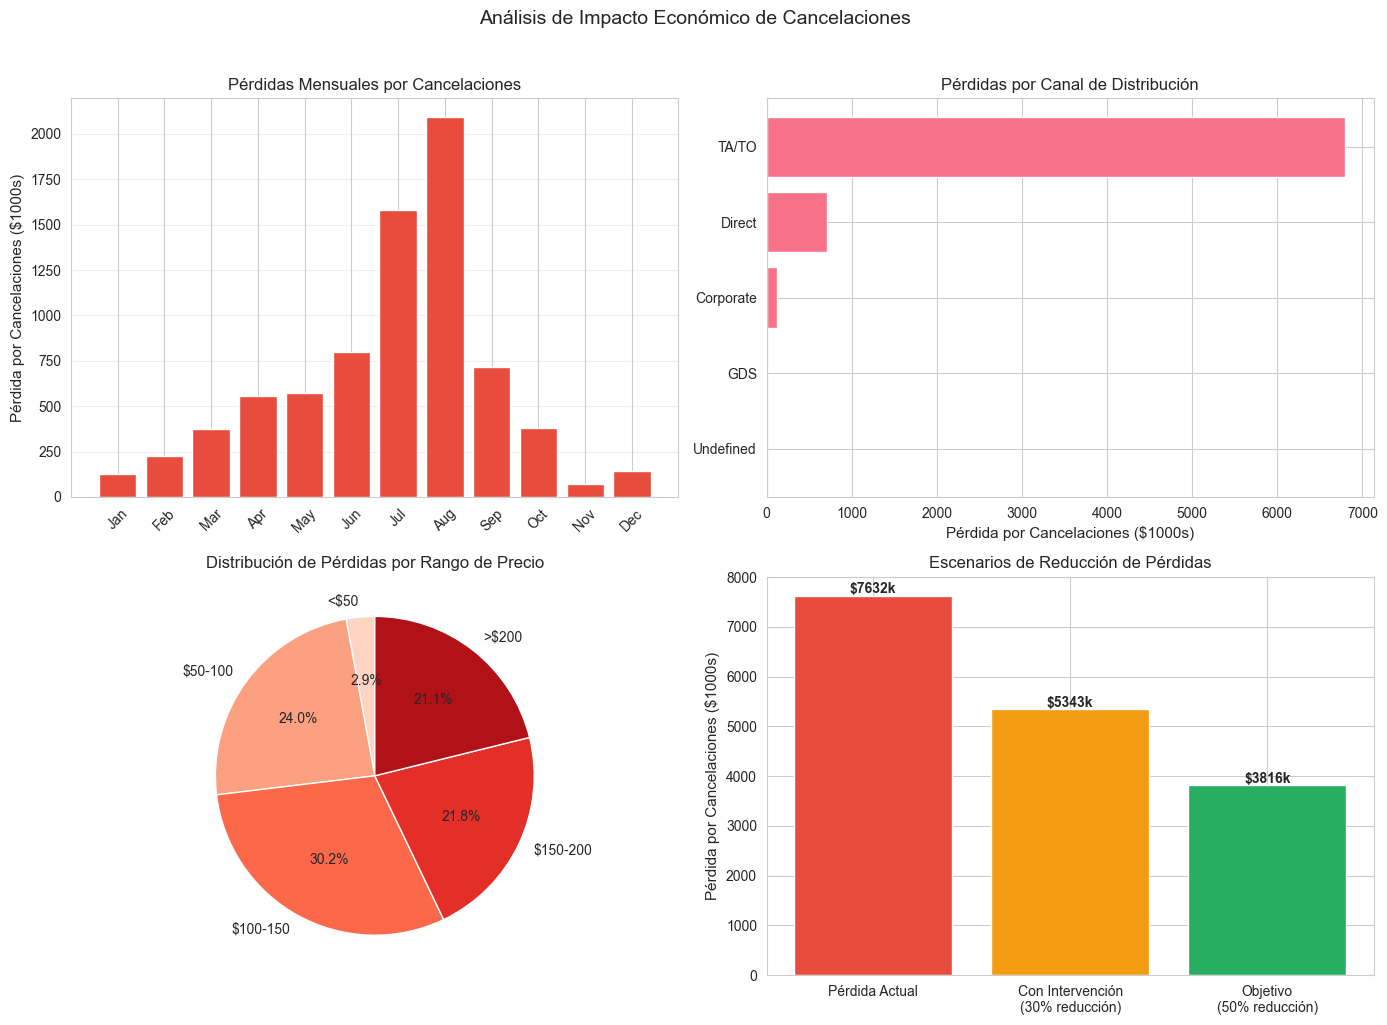

In [17]:
# Visualización del impacto económico
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Pérdidas por mes
monthly_loss = df_econ[df_econ['is_canceled'] == 1].groupby('arrival_date_month')['revenue_potential'].sum()
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
monthly_loss = monthly_loss.reindex(month_order, fill_value=0) / 1000  # En miles
axes[0, 0].bar(range(12), monthly_loss.values, color='#e74c3c')
axes[0, 0].set_xticks(range(12))
axes[0, 0].set_xticklabels([m[:3] for m in month_order], rotation=45)
axes[0, 0].set_ylabel('Pérdida por Cancelaciones ($1000s)')
axes[0, 0].set_title('Pérdidas Mensuales por Cancelaciones')
axes[0, 0].grid(axis='y', alpha=0.3)

# Pérdidas por canal de distribución
channel_loss = df_econ[df_econ['is_canceled'] == 1].groupby('distribution_channel')['revenue_potential'].sum()
channel_loss = channel_loss.sort_values(ascending=True) / 1000  # En miles
axes[0, 1].barh(range(len(channel_loss)), channel_loss.values)
axes[0, 1].set_yticks(range(len(channel_loss)))
axes[0, 1].set_yticklabels(channel_loss.index)
axes[0, 1].set_xlabel('Pérdida por Cancelaciones ($1000s)')
axes[0, 1].set_title('Pérdidas por Canal de Distribución')

# Distribución de pérdidas por rango de ADR
df_econ['adr_range'] = pd.cut(df_econ['adr'], bins=[0, 50, 100, 150, 200, 1000],
                              labels=['<$50', '$50-100', '$100-150', '$150-200', '>$200'])
loss_by_adr = df_econ[df_econ['is_canceled'] == 1].groupby('adr_range')['revenue_potential'].sum() / 1000
axes[1, 0].pie(loss_by_adr.values, labels=loss_by_adr.index, autopct='%1.1f%%',
              startangle=90, colors=sns.color_palette('Reds', len(loss_by_adr)))
axes[1, 0].set_title('Distribución de Pérdidas por Rango de Precio')

# Comparación: Pérdida actual vs potencial recuperación
scenarios = ['Pérdida Actual', 'Con Intervención\n(30% reducción)', 'Objetivo\n(50% reducción)']
values = [canceled_revenue/1000, canceled_revenue*0.7/1000, canceled_revenue*0.5/1000]
colors_bar = ['#e74c3c', '#f39c12', '#27ae60']
bars = axes[1, 1].bar(range(3), values, color=colors_bar)
axes[1, 1].set_xticks(range(3))
axes[1, 1].set_xticklabels(scenarios)
axes[1, 1].set_ylabel('Pérdida por Cancelaciones ($1000s)')
axes[1, 1].set_title('Escenarios de Reducción de Pérdidas')
for i, v in enumerate(values):
    axes[1, 1].text(i, v + 50, f'${v:.0f}k', ha='center', fontweight='bold')

plt.suptitle('Análisis de Impacto Económico de Cancelaciones', fontsize=14, y=1.02)
plt.tight_layout()
save_figure(fig, '03_economic_impact')
plt.show()

## 3.10 Resumen de Hallazgos y Recomendaciones

In [20]:
print("RESUMEN DE HALLAZGOS PRINCIPALES")
print("=" * 80)

hallazgos = f"""
1. FACTORES CRÍTICOS DE CANCELACIÓN:
   • Lead time: las reservas con más de 60 días de anticipación tienen mayor probabilidad de cancelarse.
   • Tipo de depósito: cuando se exige depósito no reembolsable, las cancelaciones caen de forma notable.
   • Tipo de hotel: el City Hotel presenta más cancelaciones que el Resort, lo que sugiere diferencias por perfil de cliente.
   • Canal de distribución: algunos canales intermedios concentran tasas de cancelación muy por encima del promedio.

2. SEGMENTOS DE ALTO RIESGO:
   • Un grupo importante de reservas combina varios factores de riesgo: lead time largo, sin depósito y canal intermediado.
   • Estos casos representan una parte considerable de las pérdidas potenciales de ingresos.

3. MODELO PREDICTIVO:
   • La regresión logística mostró buena capacidad para diferenciar entre reservas canceladas y no canceladas.
   • El modelo resalta variables clave (lead_time, depósito, canal) y permite anticipar reservas críticas.
"""

print(hallazgos)

print("\nRECOMENDACIONES PRINCIPALES")
print("=" * 80)

recomendaciones = """
CORTO PLAZO:
1. Reforzar políticas de depósito en reservas con mucha anticipación.
2. Implementar alertas internas para reservas que combinan varios factores de riesgo.
3. Revisar acuerdos con los canales de distribución que concentran más cancelaciones.

MEDIANO PLAZO:
4. Ajustar precios y promociones diferenciando entre hotel urbano y resort.
5. Integrar el modelo predictivo en el proceso de reservas para priorizar seguimiento a clientes de alto riesgo.
"""

print(recomendaciones)


# Guardar resumen
with open('../reports/03_desarrollo_resultados.txt', 'w', encoding='utf-8') as f:
    f.write("DESARROLLO DE ESTRATEGIA - RESULTADOS PRINCIPALES\n")
    f.write("=" * 60 + "\n")
    f.write(hallazgos)
    f.write("\n" + "=" * 60 + "\n")
    f.write(recomendaciones)

print("\n✓ Análisis completo ejecutado")
print("✓ Modelo entrenado y validado")
print("✓ Visualizaciones guardadas en reports/figures/")
print("✓ Resultados guardados en reports/")

RESUMEN DE HALLAZGOS PRINCIPALES

1. FACTORES CRÍTICOS DE CANCELACIÓN:
   • Lead time: las reservas con más de 60 días de anticipación tienen mayor probabilidad de cancelarse.
   • Tipo de depósito: cuando se exige depósito no reembolsable, las cancelaciones caen de forma notable.
   • Tipo de hotel: el City Hotel presenta más cancelaciones que el Resort, lo que sugiere diferencias por perfil de cliente.
   • Canal de distribución: algunos canales intermedios concentran tasas de cancelación muy por encima del promedio.

2. SEGMENTOS DE ALTO RIESGO:
   • Un grupo importante de reservas combina varios factores de riesgo: lead time largo, sin depósito y canal intermediado.
   • Estos casos representan una parte considerable de las pérdidas potenciales de ingresos.

3. MODELO PREDICTIVO:
   • La regresión logística mostró buena capacidad para diferenciar entre reservas canceladas y no canceladas.
   • El modelo resalta variables clave (lead_time, depósito, canal) y permite anticipar reserv